In [103]:
%load_ext autoreload
%autoreload 2
    
import pandas as pd
import torch
import dgl
import torch.nn as nn
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from sklearn.metrics import auc
import os

from utils.load_networkx import networkx_feat
from utils.macro_dataset import MacroDataset
from torch.utils.data import DataLoader
from utils.meter import Meter_v2
from utils import plot

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [104]:
class inference():
    def __init__(self, MODEL_PATH, DF_PATH, TXT_DATA_PATH, MON_SMILES, BOND_SMILES, DESCRIPTORS,
                 SCALER, SEED, TASK, LABELNAME, MODEL):

        self._NX_GRAPHS = networkx_feat(TXT_DATA_PATH = TXT_DATA_PATH, MON_SMILES = MON_SMILES,
                                        BOND_SMILES = BOND_SMILES, DESCRIPTORS = DESCRIPTORS, SPLIT = SPLIT, SEED = SEED, SCALER = SCALER)
        self._dataset = MacroDataset(DF_PATH = DF_PATH, TASK = TASK, LABELNAME = LABELNAME, MODEL = MODEL,
                                     NX_GRAPHS = self._NX_GRAPHS)
        
        self._num_node_descriptors = len(list(self._dataset._nx_graphs['node_feats'].values())[0])
        self._num_edge_descriptors = len(list(self._dataset._nx_graphs['edge_feats'].values())[0])
        self._model_name = MODEL
        self._custom_params = {}
        
        if torch.cuda.is_available():
            self._device = torch.device('cuda')
        else:
            self._device = torch.device('cpu')
        
        if self._dataset.task == 'classification':
            if self._dataset.classtype == 'binary':
                self._loss_criterion = nn.BCEWithLogitsLoss(reduction='none')
            elif self._dataset.classtype == 'multiclass':
                self._loss_criterion = nn.CrossEntropyLoss()
            elif self._dataset.classtype == 'multilabel':
                self._loss_criterion = nn.BCEWithLogitsLoss(reduction='none')
        elif self._dataset.task == 'regression':
            self._loss_criterion = nn.SmoothL1Loss(reduction='none')

        self._config_update()
        self._load_hparams()
        
    def _config_update(self):
        ''' Utility function for update of configuration dictionary '''
        self._exp_config = {}
        self._exp_config['model'] = self._model_name
        self._exp_config['n_tasks'] = self._dataset.n_tasks
        self._exp_config['in_node_feats'] = self._num_node_descriptors
        self._exp_config['in_edge_feats'] = self._num_edge_descriptors

    def _load_hparams(self):
        ''' Utility function for loading default hyperparameters and updating them to reflect custom hyperparameters '''
        with open('{}/configure.json'.format(MODEL_PATH), 'r') as f:
            config = json.load(f)
        config.update(self._custom_params)
        self._exp_config.update(config)
        
    def _load_model(self):
        ''' Utility function for loading model 
        
        Returns:
        model: dgllife model, Predictor with set hyperparameters
        '''
        if self._model_name == 'GCN':
            from dgllife.model import GCNPredictor
            model = GCNPredictor(
                in_feats=self._exp_config['in_node_feats'],
                hidden_feats=[self._exp_config['gnn_hidden_feats']] * self._exp_config['num_gnn_layers'],
                activation=[F.relu] * self._exp_config['num_gnn_layers'],
                residual=[self._exp_config['residual']] * self._exp_config['num_gnn_layers'],
                batchnorm=[self._exp_config['batchnorm']] * self._exp_config['num_gnn_layers'],
                dropout=[self._exp_config['dropout']] * self._exp_config['num_gnn_layers'],
                predictor_hidden_feats=self._exp_config['predictor_hidden_feats'],
                predictor_dropout=self._exp_config['dropout'],
                n_tasks=self._exp_config['n_tasks'])
        elif self._model_name == 'GAT':
            from dgllife.model import GATPredictor
            model = GATPredictor(
                in_feats=self._exp_config['in_node_feats'],
                hidden_feats=[self._exp_config['gnn_hidden_feats']] * self._exp_config['num_gnn_layers'],
                num_heads=[self._exp_config['num_heads']] * self._exp_config['num_gnn_layers'],
                feat_drops=[self._exp_config['dropout']] * self._exp_config['num_gnn_layers'],
                attn_drops=[self._exp_config['dropout']] * self._exp_config['num_gnn_layers'],
                alphas=[self._exp_config['alpha']] * self._exp_config['num_gnn_layers'],
                residuals=[self._exp_config['residual']] * self._exp_config['num_gnn_layers'],
                predictor_hidden_feats=self._exp_config['predictor_hidden_feats'],
                predictor_dropout=self._exp_config['dropout'],
                n_tasks=self._exp_config['n_tasks']
            )
        elif self._model_name == 'Weave':
            from dgllife.model import WeavePredictor
            model = WeavePredictor(
                node_in_feats=self._exp_config['in_node_feats'],
                edge_in_feats=self._exp_config['in_edge_feats'],
                num_gnn_layers=self._exp_config['num_gnn_layers'],
                gnn_hidden_feats=self._exp_config['gnn_hidden_feats'],
                graph_feats=self._exp_config['graph_feats'],
                gaussian_expand=self._exp_config['gaussian_expand'],
                n_tasks=self._exp_config['n_tasks']
            )
        elif self._model_name == 'MPNN':
            from dgllife.model import MPNNPredictor
            model = MPNNPredictor(
                node_in_feats=self._exp_config['in_node_feats'],
                edge_in_feats=self._exp_config['in_edge_feats'],
                node_out_feats=self._exp_config['node_out_feats'],
                edge_hidden_feats=self._exp_config['edge_hidden_feats'],
                num_step_message_passing=self._exp_config['num_step_message_passing'],
                num_step_set2set=self._exp_config['num_step_set2set'],
                num_layer_set2set=self._exp_config['num_layer_set2set'],
                n_tasks=self._exp_config['n_tasks']
            )
        elif self._model_name == 'AttentiveFP':
            from dgllife.model import AttentiveFPPredictor
            model = AttentiveFPPredictor(
                node_feat_size=self._exp_config['in_node_feats'],
                edge_feat_size=self._exp_config['in_edge_feats'],
                num_layers=self._exp_config['num_layers'],
                num_timesteps=self._exp_config['num_timesteps'],
                graph_feat_size=self._exp_config['graph_feat_size'],
                dropout=self._exp_config['dropout'],
                n_tasks=self._exp_config['n_tasks']
            )
        return model

    def _collate_molgraphs(self, data):
        ''' Utility function for batching list of datapoints for Dataloader 
        
        Args:
        data : list, list of 4-tuples, each for a single datapoint consisting of an ID, a DGLGraph, all-task labels and a binary
        mask indicating the existence of labels
        
        Returns:
        IDs : list, list of GBIDs
        bg : DGLGraph, batched DGLGraph.
        labels : Tensor of dtype float32 and shape (len(data), data.n_tasks), batched datapoint labels
        masks : Tensor of dtype float32 and shape (len(data), data.n_tasks), batched datapoint binary mask indicating the
        existence of labels.
        '''
        IDs, graphs, labels, masks = map(list, zip(*data))

        bg = dgl.batch(graphs)
        bg.set_n_initializer(dgl.init.zero_initializer)
        bg.set_e_initializer(dgl.init.zero_initializer)
        labels = torch.stack(labels, dim=0)

        if masks is None:
            masks = torch.ones(labels.shape)
        else:
            masks = torch.stack(masks, dim=0)

        return IDs, bg, labels, masks

    def _predict(self, model, bg):
        ''' Utility function for moving batched graph and node/edge feats to device
        
        Args:
        model : dgllife model, Predictor with set hyperparameters
        bg : DGLGraph, batched DGLGraph
        
        Returns:
        model(bg, node_feats, edge_feats) : model moved to device
        '''
        bg = bg.to(self._device)
        if self._model_name in ['GCN', 'GAT']:
            node_feats = bg.ndata.pop('h').to(self._device)
            return model(bg, node_feats)
        else:
            node_feats = bg.ndata.pop('h').to(self._device)
            edge_feats = bg.edata.pop('e').to(self._device)
            return model(bg, node_feats, edge_feats)


    def _run_an_eval_epoch(self, model, data_loader):
        ''' Utility function for running an evaluation (validation/test) epoch
        
        Args:
        model : dgllife model, Predictor with set hyperparameters
        data_loader : DataLoader, DataLoader for train, validation, or test
        
        Returns:
        metric_dict : dict, dictionary of metric names and corresponding evaluation values
        '''

        model.eval()
        eval_meter = Meter_v2()

        ID_list = []
        y_true_list = []
        y_pred_list = []
        loss_list = []
        
        with torch.no_grad():
            for batch_id, batch_data in enumerate(data_loader):
                IDs, bg, labels, masks = batch_data
                ID_list.append(IDs)
                
                labels, masks = labels.to(self._device), masks.to(self._device)
                y_true_list.append(labels)
                
                logits = self._predict(model, bg)
                y_pred = torch.sigmoid(logits)
                y_pred_list.append(y_pred)
                
                eval_meter.update(logits, labels, masks)
                
                if self._dataset.task == 'classification':
                    if self._dataset.classtype == 'multiclass':
                        losslabels = torch.max(labels, 1)[1]
                    else:
                        losslabels = labels
                else:
                    losslabels = labels
                
                loss = (self._loss_criterion(logits, losslabels) * (masks != 0).float())
                loss_list.append(loss)

        ID_list = sum(ID_list, [])
        y_pred_list = torch.cat(y_pred_list).flatten().tolist()
        y_true_list = torch.cat(y_true_list).flatten().tolist()
        loss_list = torch.cat(loss_list).flatten().tolist()

        df = pd.DataFrame({'ID': ID_list, 'y_true': y_true_list, 'y_pred': y_pred_list, 'loss': loss_list})
        
        if self._dataset.task == 'classification':
            plotvals = eval_meter.compute_metric('roc_curve')
            if self._dataset.classtype == 'binary':
                metric_dict = {'loss': np.mean(loss_list), 'ROC-AUC': np.mean(eval_meter.compute_metric('roc_auc_score')), 'F1': np.mean(eval_meter.compute_metric('f1_score')), 'recall': np.mean(eval_meter.compute_metric('recall_score')), 'precision': np.mean(eval_meter.compute_metric('precision_score')), 'accuracy': np.mean(eval_meter.compute_metric('accuracy_score'))}
            elif self._dataset.classtype == 'multiclass':
                metric_dict = {'loss': np.mean(loss_list), 'ROC-AUC': np.mean(eval_meter.compute_metric('roc_auc_score')), 'F1': np.mean(eval_meter.compute_metric('f1_score')), 'recall': np.mean(eval_meter.compute_metric('recall_score')), 'precision': np.mean(eval_meter.compute_metric('precision_score')), 'accuracy': np.mean(eval_meter.compute_metric('accuracy_score'))}
            elif self._dataset.classtype == 'multilabel':
                metric_dict = {'loss': np.mean(loss_list), 'ROC-AUC': np.mean(eval_meter.compute_metric('roc_auc_score')), 'F1': np.mean(eval_meter.compute_metric('f1_score')), 'recall': np.mean(eval_meter.compute_metric('recall_score')), 'precision': np.mean(eval_meter.compute_metric('precision_score')), 'accuracy': np.mean(eval_meter.compute_metric('accuracy_score')), 'hamming loss': np.mean(eval_meter.compute_metric('hamming_loss'))}
        elif self._dataset.task == 'regression':
            plotvals = eval_meter.inverse(self._normalizer)
            metric_dict = {'rmse': np.mean(eval_meter.compute_metric('rmse')), 'L1loss': np.mean(loss_list), 'r2': np.mean(eval_meter.compute_metric('r2')), 'mae': np.mean(eval_meter.compute_metric('mae')), 'spearmanr': np.mean(eval_meter.compute_metric('spearmanr')), 'kendalltau': np.mean(eval_meter.compute_metric('kendalltau'))}
    
        return metric_dict, plotvals, df

    def rocauc_plot(self, fig_path):
        ''' Plots ROC-AUC curve for classification task
        
        Args:
        plottype : str, dataset to plot, 'val' for validation or 'test' for test
        fig_path : str, path to save figure
        '''
        mean_fpr = self.plotvals[0]
        mean_tpr = self.plotvals[1]
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)

        plt.figure()
        lw = 2
        plt.plot(mean_fpr, mean_tpr, color='#2C7FFF',lw=lw)
        plt.plot([0, 1], [0, 1], color='#B2B2B2', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate', fontsize=18)
        plt.ylabel('True Positive Rate', fontsize=18)
        plt.tick_params(axis='both', which='major', labelsize=16)
        plt.text(0.95, 0.03, 'ROC-AUC = %0.2f' % (mean_auc),
        verticalalignment='bottom', horizontalalignment='right',
        fontsize=18)
        
        plt.tight_layout()
        plt.savefig(fig_path + '/inference.png')
        plt.show()

    def main(self):
        
        self.model_load = self._load_model()
        model = self.model_load.to(self._device)
        model = torch.load("{}/fullmodel.pt".format(MODEL_PATH))

        data_loader = DataLoader(dataset=self._dataset.dgl_data['train'], batch_size=self._exp_config['batch_size'], shuffle=True, 
                   collate_fn=self._collate_molgraphs)
        
        eval_results = self._run_an_eval_epoch(model, data_loader)
        self.metrics = eval_results[0]
        self.plotvals = eval_results[1]
        self.df = eval_results[2]
        print(self.metrics)
        self.rocauc_plot(MODEL_PATH)

        return self.df

In [105]:
MON_SMILES = 'tables_poly/SMILES_polymers_monomer.txt' # Monomer smiles code .txt file
BOND_SMILES = 'tables_poly/SMILES_polymers_bond.txt' # Bond smiles code .txt file

DESCRIPTORS = 'unique_descriptors.json'

TXT_DATA_PATH = 'shoshana_polymers/dataset_uniform/classification/' # Folder of .txt files for graphs
DF_PATH = 'tables_poly/immuno_polymers.txt' # File containing IDs and immunogenic label
MODEL_PATH = 'past_trials/AttentiveFP/100_epochs_w_inference'

SPLIT = '1.0,0.0,0.0'

SEED = 111
TASK = 'classification'
MODEL = 'AttentiveFP'
LABELNAME = 'immunogenic'
SCALER = 'minmax'

In [106]:
%%capture
a = inference(MODEL_PATH, DF_PATH, TXT_DATA_PATH, MON_SMILES, BOND_SMILES, DESCRIPTORS, SCALER, SEED, TASK, LABELNAME, MODEL)

{'loss': 0.5704142842676095, 'ROC-AUC': 0.8985206349206348, 'F1': 0.823913043478261, 'recall': 0.8239130434782609, 'precision': 0.8239130434782609, 'accuracy': 0.8239130434782609}


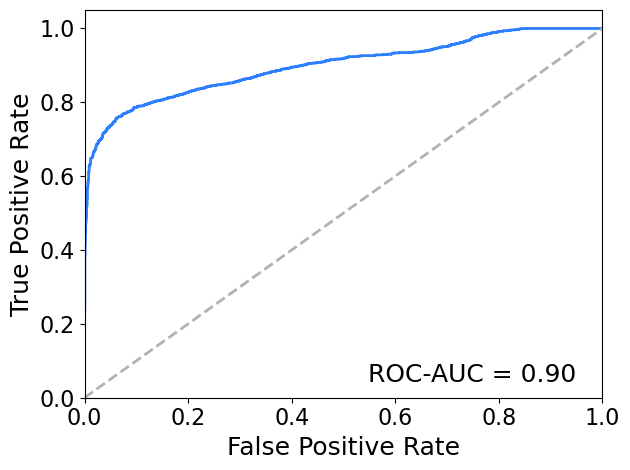

In [91]:
df = a.main()

In [36]:
# df[df.apply(lambda row: row['y_true'] - row['y_pred'] > 0.5, axis=1)]

In [68]:
# Extract numeric part from ID
df['ID_num'] = df['ID'].str.extract(r'(\d+)').astype(int)

# Create a new column for grouping every 200 IDs
df['group'] = (df['ID_num'] - 1) // 200

# df['rounded'] = df['y_pred'].apply(lambda x: np.around(x))

# Now you can group by this new column and aggregate as needed
grouped = df.groupby('group').agg({
    # 'rounded': 'mean',
    'y_true': 'mean',  # Example aggregation: mean of y_true
    'y_pred': 'mean',  # Example aggregation: mean of y_pred
    'loss': 'sum'      # Example aggregation: sum of loss
})

In [70]:
grouped['rounded'] = grouped['y_pred'].apply(lambda x: np.around(x))
print("incorrect predictions: " + str((grouped['y_true'] - grouped['rounded']).sum()))
grouped.drop(['rounded'], axis=1)

incorrect predictions: 4.0


,y_true,y_pred,loss
group,,,
0,0.0,0.141168,31.238019
1,0.0,0.049270,10.336854
2,1.0,0.996774,0.659675
3,1.0,0.980688,5.811985
4,1.0,0.926547,18.459224
5,1.0,0.910423,26.467772
6,0.0,0.005684,1.140377
7,0.0,0.003169,0.634810
8,0.0,0.325611,132.397220


In [77]:
df['y_pred'].map(lambda x: round(x)).value_counts()

y_pred
1    4600
Name: count, dtype: int64

In [78]:
df['y_true'].map(lambda x: round(x)).value_counts()

y_true
1    2800
0    1800
Name: count, dtype: int64

## Graph Characteristics:

In [ ]:
# Edge Characteristics 
# [idx for idx in NX_GRAPHS['UID93'].edges ] # (i,j)
# [NX_GRAPHS['UID93'].edges[idx]['label'] for idx in NX_GRAPHS['UID93'].edges ] # 'AMB'
# [NX_GRAPHS['UID93'].edges[idx]['e'] for idx in NX_GRAPHS['UID93'].edges ] # Feature

# Node Characteristics
# [idx for idx in NX_GRAPHS['UID93'].nodes ] # (i)
# [NX_GRAPHS['UID93'].nodes[idx]['label'] for idx in NX_GRAPHS['UID93'].nodes ] # 'A'
# [NX_GRAPHS['UID93'].nodes[idx]['h'] for idx in NX_GRAPHS['UID93'].nodes ] # Feature